In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pickle

In [2]:
%matplotlib inline

In [3]:
years = ['2016', '2017', '2018', '2019', '2020']

# Creating Database

## Loading vehicle data

In [4]:
def clean_state(x):
    for char in '(1234567890)':
        x = x.replace(char,'')
    x = x.strip(' ')
    return x

traffic_dfs = {}
for year in years:
    url = "https://www.fhwa.dot.gov/policyinformation/statistics/{}/mv1.cfm".format(year)
    html = requests.get(url).content
    tempdf = pd.read_html(html)[0]
    tempdf.dropna(inplace=True)
    tempdf.columns = list(range(16))
    tempdf = tempdf[[0,3,6,9,12,15]]
    tempdf.columns = ['State', 'Automobiles_'+year, 'Buses_'+year, 'Trucks_'+year, 'Motorcycles_'+year, 'All_'+year]
    tempdf['State'] = tempdf['State'].map(clean_state)
    tempdf = tempdf[tempdf['State'] != 'Total']
    tempdf.loc[tempdf['State'] == 'Dist. of Col.', 'State'] = 'District of Columbia'
    
    traffic_dfs[year] = tempdf

In [5]:
dfs = [df.set_index('State') for df in traffic_dfs.values()]
trafficdf = pd.concat(dfs, axis=1)

In [6]:
trafficdf.head()

,Automobiles_2016,Buses_2016,Trucks_2016,Motorcycles_2016,All_2016,Automobiles_2017,Buses_2017,Trucks_2017,Motorcycles_2017,All_2017,...,Automobiles_2019,Buses_2019,Trucks_2019,Motorcycles_2019,All_2019,Automobiles_2020,Buses_2020,Trucks_2020,Motorcycles_2020,All_2020
State,,,,,,,,,,,,,,,,,,,,,
Alabama,2284443,6238,3067917,109703,5468301,2065463,5682,2872743,112185,5056073,...,2109108,5592,3065778,107730,5288208,2035376.0,5624.0,3164439.0,114901.0,5320340.0
Alaska,183259,8119,571287,31949,794614,173487,8080,591079,31859,804505,...,178516,8645,579985,28129,795275,171144.0,8620.0,586281.0,26781.0,792826.0
Arizona,2377962,9016,3233330,166583,5786891,2391624,9051,3399704,164055,5964434,...,2405959,8407,3407708,160486,5982559,2410018.0,8486.0,3514203.0,121074.0,6053781.0
Arkansas,942604,11931,1762765,90838,2808138,926789,11941,1805510,89457,2833697,...,886647,12032,1833636,169796,2902111,872437.0,12044.0,1859091.0,169797.0,2913369.0
California,14768392,98622,14511913,842106,30221033,14860967,99917,14991714,842543,30795141,...,14894912,100526,15443454,808377,31247270,14201400.0,100828.0,15310597.0,785424.0,30398249.0


## Adding Population Numbers

In [7]:
url = "https://www.infoplease.com/us/states/state-population-by-rank"
html = requests.get(url).content
tempdf = pd.read_html(html)[0][['State', '2020 Census']]

new_cols = list(tempdf.columns)
new_cols[-1] = 'Population_2020'
tempdf.columns = new_cols
tempdf = tempdf[tempdf['State'] != 'Total U.S.']
tempdf.loc[tempdf['State'] == 'DC', 'State'] = 'District of Columbia'
tempdf.set_index('State', inplace=True)


In [8]:
trafficdf = pd.concat([trafficdf, tempdf], axis=1)

## Adding Licensed Driver Numbers

In [9]:
url = "https://www.statista.com/statistics/198029/total-number-of-us-licensed-drivers-by-state/"
html = requests.get(url).content
licensedf = pd.read_html(html)[0]
licensedf.rename(columns = {'Characteristic':'State', "Number of licensed drivers":"Licensed_Drivers_2020"}, inplace=True)
licensedf.set_index('State', inplace=True)

In [10]:
trafficdf = pd.concat([trafficdf, licensedf], axis=1)

## Adding Minimum Age For Driver's License

In [11]:
url = "https://www.verywellfamily.com/driving-age-by-state-2611172#toc-learners-permits"
html = requests.get(url).content
minage = pd.read_html(html)[0]
minage.columns = minage.iloc[0]
minage.drop(index=[0], inplace=True)
minage.set_index('State', inplace=True)
minage.rename(columns = {"Learner's Permit":'Learners_Permit', "Restricted License":"Restricted_License", "Full License":"Full_License"}, inplace=True)
minage.head()

,Learners_Permit,Restricted_License,Full_License
State,,,
Alabama,15,16,17
Alaska,14,16,"16, 6 mos."
Arizona,"15, 6 mos.",16,"16, 6 mos."
Arkansas,14,16,18
California,"15, 6 mos.",16,17


In [12]:
def clean_age(val):
    if type(val) == float:
        return val
    age_split = val.split(', ')
    age = float(age_split[0])
    if len(age_split) > 1:
        age += float(age_split[1][0])/12
    return age

minage['Learners_Permit'] = minage['Learners_Permit'].map(clean_age)
minage['Restricted_License'] = minage['Restricted_License'].map(clean_age)
minage['Full_License'] = minage['Full_License'].map(clean_age)

In [13]:
trafficdf = pd.concat([trafficdf, minage], axis=1)

In [14]:
trafficdf.head()

,Automobiles_2016,Buses_2016,Trucks_2016,Motorcycles_2016,All_2016,Automobiles_2017,Buses_2017,Trucks_2017,Motorcycles_2017,All_2017,...,Automobiles_2020,Buses_2020,Trucks_2020,Motorcycles_2020,All_2020,Population_2020,Licensed_Drivers_2020,Learners_Permit,Restricted_License,Full_License
State,,,,,,,,,,,,,,,,,,,,,
Alabama,2284443,6238,3067917,109703,5468301,2065463,5682,2872743,112185,5056073,...,2035376.0,5624.0,3164439.0,114901.0,5320340.0,5024279,4042900,15.0,16.0,17.0
Alaska,183259,8119,571287,31949,794614,173487,8080,591079,31859,804505,...,171144.0,8620.0,586281.0,26781.0,792826.0,733391,518872,14.0,16.0,16.5
Arizona,2377962,9016,3233330,166583,5786891,2391624,9051,3399704,164055,5964434,...,2410018.0,8486.0,3514203.0,121074.0,6053781.0,7151502,5681495,15.5,16.0,16.5
Arkansas,942604,11931,1762765,90838,2808138,926789,11941,1805510,89457,2833697,...,872437.0,12044.0,1859091.0,169797.0,2913369.0,3011524,2153929,14.0,16.0,18.0
California,14768392,98622,14511913,842106,30221033,14860967,99917,14991714,842543,30795141,...,14201400.0,100828.0,15310597.0,785424.0,30398249.0,39538223,27005302,15.5,16.0,17.0


## Saving Dataframe

In [15]:
len(trafficdf)

51

In [16]:
trafficdf.to_pickle('Vehicle_Population_Stats.pkl')

# Analysis

In [20]:
sns.set(font_scale=1)

Text(0.5, 1.0, 'Percentage of Population with Drivers License, per State')

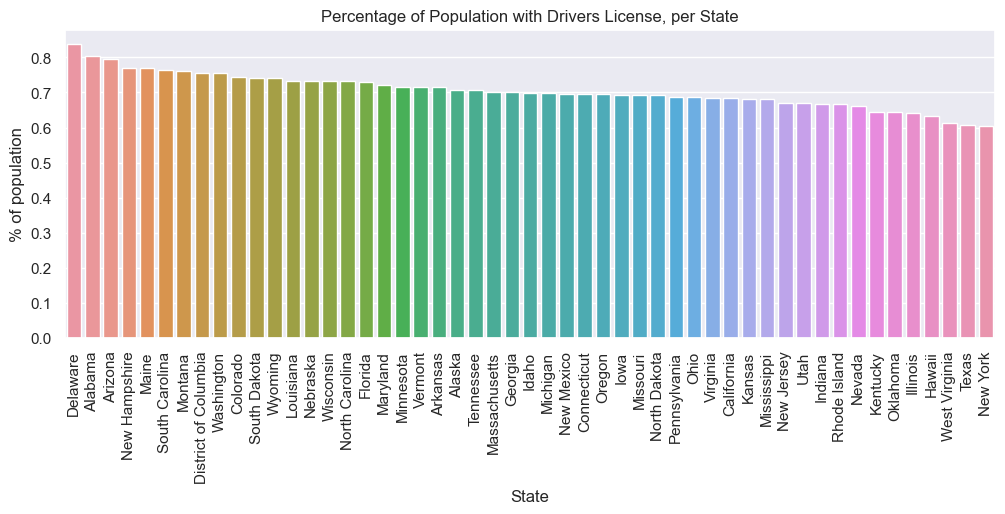

In [33]:
plt.figure(figsize=(12,4))
y = trafficdf['Licensed_Drivers_2020']/trafficdf['Population_2020']
plt.xticks(rotation=90)
sns.barplot(
    x=trafficdf.index, 
    y=y, 
    order=y.sort_values(ascending=False).index, 
)
plt.ylabel("% of population")
plt.title('Percentage of Population with Drivers License, per State')

Text(0.5, 1.0, 'Minimum Age Needed for Full Drivers License')

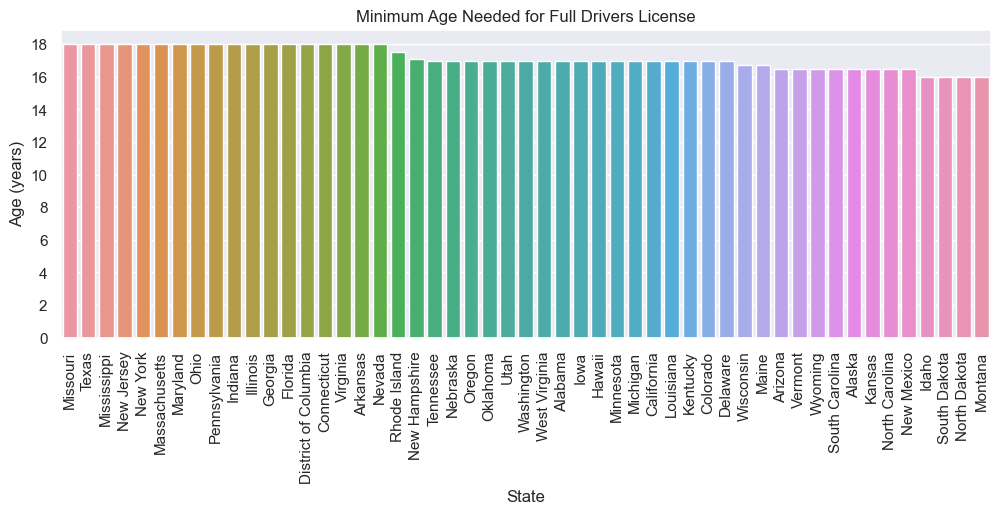

In [35]:
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 20, step=2))
sns.barplot(x=trafficdf.index, y='Full_License', data=trafficdf, order=trafficdf['Full_License'].sort_values(ascending=False).index)
plt.ylabel('Age (years)')
plt.title('Minimum Age Needed for Full Drivers License')

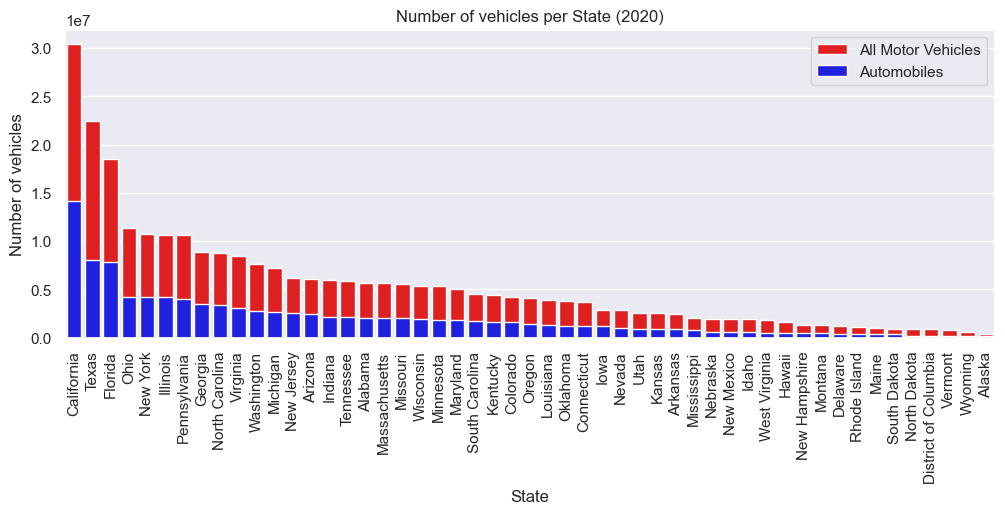

In [23]:
fig, ax = plt.subplots(figsize=(12,4))
plt.xticks(rotation=90)
sns.barplot(
    data=trafficdf, 
    x=trafficdf.index, 
    y='All_2020', 
    order=trafficdf['All_2020'].sort_values(ascending=False).index, 
    ax=ax, 
    color='Red', 
    label='All Motor Vehicles'
)

sns.barplot(
    data=trafficdf, 
    x=trafficdf.index, 
    y='Automobiles_2020', 
    order=trafficdf['Automobiles_2020'].sort_values(ascending=False).index, 
    ax=ax, 
    color='Blue',
    label='Automobiles'
)

ax.set_ylabel('Number of vehicles')
plt.title("Number of vehicles per State (2020)")
ax.legend()

plt.show()

In [ ]:
y1 = trafficdf['All_2020']/trafficdf['Population_2020']
y2 = trafficdf['Automobiles_2020']/trafficdf['Population_2020']

fig, ax = plt.subplots(figsize=(12,4))
plt.xticks(rotation=90)
sns.barplot(
    x=trafficdf.index, 
    y=y1, 
    order=y1.sort_values(ascending=False).index, 
    ax=ax, 
    color='Red', 
    label='All Motor Vehicles'
)
sns.barplot(
    x=trafficdf.index, 
    y=y2, 
    order=y2.sort_values(ascending=False).index,
    ax=ax, 
    color='Blue',
    label='Automobiles'
)

ax.set_ylabel('Vehicles per Capita')
plt.title("Number of vehicles per Capita, per State (2020)")
ax.legend()

plt.show()

In [ ]:
y1 = trafficdf['All_2020']/trafficdf['Licensed_Drivers_2020']
y2 = trafficdf['Automobiles_2020']/trafficdf['Licensed_Drivers_2020']

fig, ax = plt.subplots(figsize=(12,4))
plt.xticks(rotation=90)
sns.barplot(
    x=trafficdf.index, 
    y=y1, 
    order=y1.sort_values(ascending=False).index, 
    ax=ax, 
    color='Red', 
    label='All Motor Vehicles'
)
sns.barplot(
    x=trafficdf.index, 
    y=y2, 
    order=y2.sort_values(ascending=False).index,
    ax=ax, 
    color='Blue',
    label='Automobiles'
)

ax.set_ylabel('Vehicles per Capita')
plt.title("Number of Vehicles per Registered Driver, per State (2020)")
ax.legend()

plt.show()

In [ ]:
top5 = trafficdf['All_2020'].sort_values(ascending=False).index[:5]
trafficdf.loc[top5][['All_2016', 'All_2017', 'All_2018', 'All_2019', 'All_2020']].T.plot()
plt.title("growth of number of vehicles in states with most vehicles")
plt.tight_layout()

In [ ]:
top5 = y1.sort_values(ascending=False).index[:5]
trafficdf.loc[top5][['All_2016', 'All_2017', 'All_2018', 'All_2019', 'All_2020']].T.plot()
plt.title("growth of number of vehicles in states with most vehicles per capita", fontsize=10)
plt.tight_layout()

In [ ]:
top5 = y2.sort_values(ascending=False).index[:5]
trafficdf.loc[top5][['All_2016', 'All_2017', 'All_2018', 'All_2019', 'All_2020']].T.plot()
plt.title("growth of number of vehicles in states with most licenses per capita", fontsize=10)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,9))
sns.set(font_scale=0.7)
sns.heatmap(trafficdf.corr(), annot=True, fmt='.2f')